In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import f1_score
import pandas as pd
import UNET
import WNET
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

Length of training per batch: 142
Length of testing per batch: 31
Training Batch:


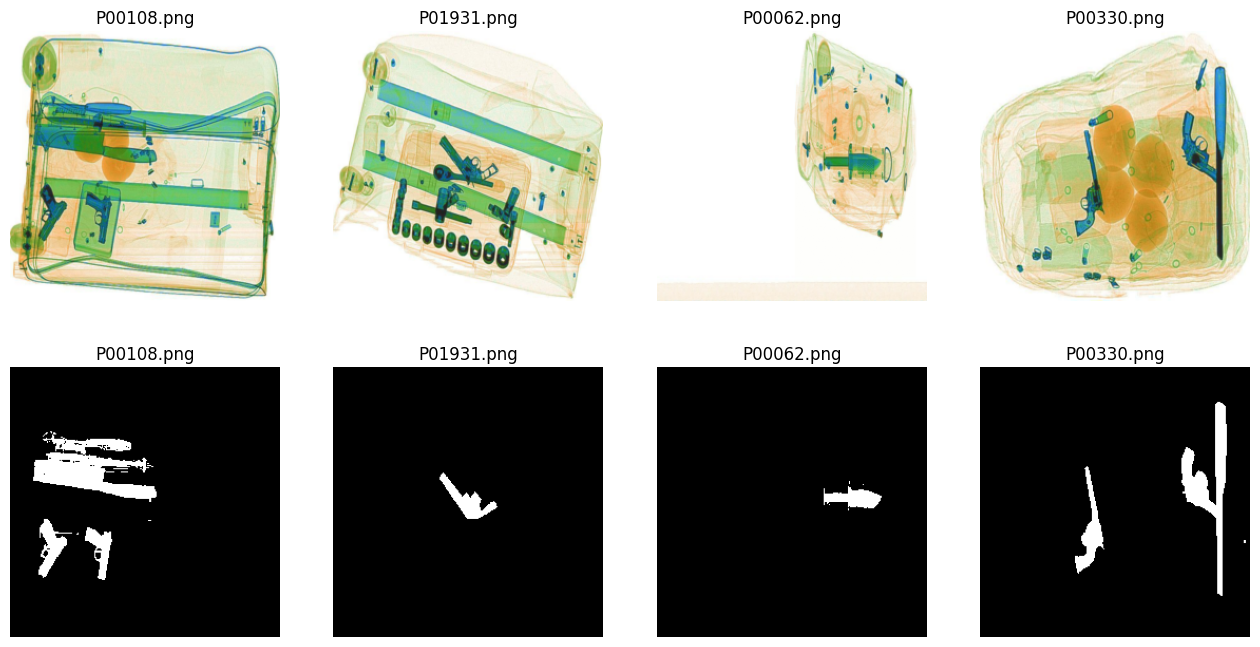

Validation Batch:


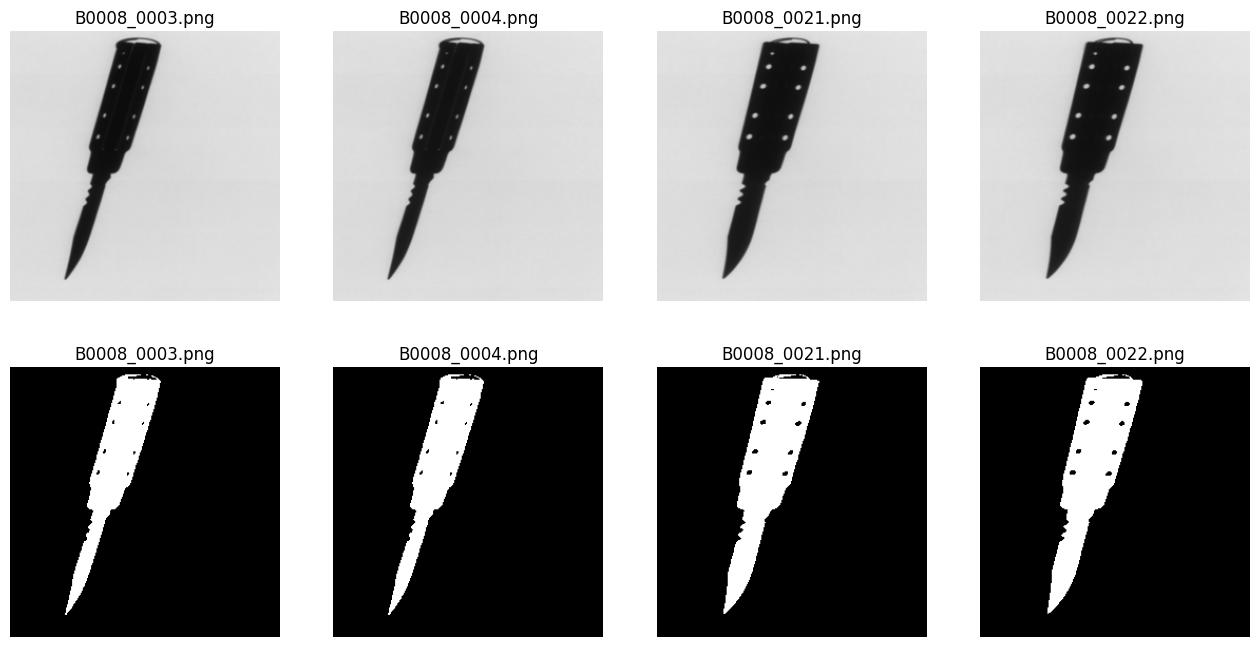

In [9]:
# Custom transformation for binarizing the mask
class BinarizeMask(object):
    def __call__(self, img):
        return img.point(lambda p: p > 0 and 255)

# Transformation for both input images and masks
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Transformation for resizing and binarizing masks to match model output size
transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust to match the model's input size
    BinarizeMask(),
    transforms.ToTensor()
])

# Dataset class for your custom dataset
class CustomDataset(Dataset):
    def __init__(self, root, transform, transform_mask):
        self.root = root
        self.transform = transform
        self.transform_mask = transform_mask
        self.img_files = sorted(os.listdir(os.path.join(root, "images")))
        self.mask_files = sorted(os.listdir(os.path.join(root, "gt")))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.root, "images", img_name)
        mask_path = os.path.join(self.root, "gt", self.mask_files[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale

        img = self.transform(img)
        mask = self.transform_mask(mask)

        return img, mask, img_name

# Set the paths to your dataset
train_dataset_path = r'F:\NOTES\Season 3.2\DIP\students_data\students_data\train'
val_dataset_path = r'F:\NOTES\Season 3.2\DIP\students_data\students_data\test'

train_dataset = CustomDataset(root=train_dataset_path, transform=transform, transform_mask=transform_mask)
val_dataset = CustomDataset(root=val_dataset_path, transform=transform, transform_mask=transform_mask)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Function to display a batch of images and masks
def show_batch(dataloader):
    images, masks, img_path = next(iter(dataloader))
    
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    
    for i in range(4):
        # Display image
        axs[0, i].imshow(images[i].permute(1, 2, 0))  # CHW to HWC
        axs[0, i].set_title(img_path[i])
        axs[0, i].axis('off')
        
        # Display mask
        axs[1, i].imshow(masks[i].squeeze(), cmap='gray')
        axs[1, i].set_title(img_path[i])
        axs[1, i].axis('off')

    plt.show()

print(f'Length of training per batch: {len(train_loader)}')
print(f'Length of testing per batch: {len(val_loader)}')

# Show a batch from train_loader
print("Training Batch:")
show_batch(train_loader)

# Show a batch from val_loader
print("Validation Batch:")
show_batch(val_loader)

In [4]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_model = UNET.UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet_model.parameters(), lr=0.001)
wnet_model = WNET.WNET().to(device)
optimizer = optim.Adam(wnet_model.parameters(), lr=0.001)


In [82]:
print("summary of unet:\n")
summary(unet_model, (3, 256, 256))

print("summary of wnet:\n")
summary(wnet_model, (3, 256, 256))

summary of unet:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
  ConvTranspose2d-11         [-1, 64, 128, 128]          32,832
             ReLU-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 64, 128, 128]          36,928
             ReLU-14 

In [12]:
def train_model(model, criterion, optimizer, dataloader, num_epochs):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, targets in tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}')

    return model

# Validation function
# Validation function
def validate_model(model, dataloader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    total_loss = 0
    results = []

    with torch.no_grad():
        for images, masks, paths in tqdm(dataloader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):  # Check if model returns multiple outputs
                outputs = outputs[0]
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            preds = preds.squeeze(1).cpu().numpy()  # Squeeze to remove the channel dimension
            masks = masks.squeeze(1).cpu().numpy()  # Squeeze to remove the channel dimension

            for pred, mask, path in zip(preds, masks, paths):
                f1 = f1_score(mask.flatten(), pred.flatten(), average='binary')
                results.append((os.path.basename(path), f1))

                # Display prediction and ground truth side by side
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(pred, cmap='gray')
                ax[0].set_title('Prediction')
                ax[0].axis('off')
                
                ax[1].imshow(mask, cmap='gray')
                ax[1].set_title('Ground Truth')
                ax[1].axis('off')

                plt.show()

    average_loss = total_loss / len(dataloader)
    return average_loss, results



In [85]:
# Train and validate UNet
print("Training UNet model...")
unet_model = train_model(unet_model, criterion, optimizer, train_loader, num_epochs=10)

# Save the trained model
torch.save(unet_model.state_dict(), 'unet_model2.pth')


Training UNet model...


Epoch 1/10: 100%|██████████| 142/142 [13:19<00:00,  5.63s/it]


Epoch 1/10, Loss: 0.8914433713530151


Epoch 2/10: 100%|██████████| 142/142 [12:46<00:00,  5.40s/it]


Epoch 2/10, Loss: 0.8914328989848285


Epoch 3/10: 100%|██████████| 142/142 [12:33<00:00,  5.31s/it]


Epoch 3/10, Loss: 0.8913637651524073


Epoch 4/10: 100%|██████████| 142/142 [15:28<00:00,  6.54s/it]


Epoch 4/10, Loss: 0.8913442001376354


Epoch 5/10: 100%|██████████| 142/142 [16:26<00:00,  6.95s/it]


Epoch 5/10, Loss: 0.8913609154627357


Epoch 6/10: 100%|██████████| 142/142 [18:28<00:00,  7.81s/it]


Epoch 6/10, Loss: 0.891437978811667


Epoch 7/10: 100%|██████████| 142/142 [22:31<00:00,  9.52s/it]


Epoch 7/10, Loss: 0.8914634996736553


Epoch 8/10: 100%|██████████| 142/142 [18:14<00:00,  7.70s/it]


Epoch 8/10, Loss: 0.8914414690413945


Epoch 9/10: 100%|██████████| 142/142 [12:10<00:00,  5.15s/it]


Epoch 9/10, Loss: 0.8912145079861225


Epoch 10/10: 100%|██████████| 142/142 [12:36<00:00,  5.33s/it]


Epoch 10/10, Loss: 0.8912403209948204


  0%|          | 0/31 [00:04<?, ?it/s]


AttributeError: 'CustomDataset' object has no attribute 'dataset'

In [15]:
unet_model.load_state_dict(torch.load("UNET_XRAY_THREAT.pth"))

unet_val_loss, unet_val_results = validate_model(unet_model, val_loader, criterion)
print(f"UNet Validation Loss: {unet_val_loss}")
# Save results to CSV
unet_df = pd.DataFrame(unet_val_results, columns=["Image", "F1 Score"])
unet_df.to_csv("unet_validation_results.csv", index=False)



RuntimeError: Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.2.weight", "encoder.2.bias", "middle.0.weight", "middle.0.bias", "middle.2.weight", "middle.2.bias", "decoder.0.weight", "decoder.0.bias", "decoder.2.weight", "decoder.2.bias", "decoder.4.weight", "decoder.4.bias", "decoder.6.weight", "decoder.6.bias". 
	Unexpected key(s) in state_dict: "backbone.body.conv1.weight", "backbone.body.bn1.weight", "backbone.body.bn1.bias", "backbone.body.bn1.running_mean", "backbone.body.bn1.running_var", "backbone.body.layer1.0.conv1.weight", "backbone.body.layer1.0.bn1.weight", "backbone.body.layer1.0.bn1.bias", "backbone.body.layer1.0.bn1.running_mean", "backbone.body.layer1.0.bn1.running_var", "backbone.body.layer1.0.conv2.weight", "backbone.body.layer1.0.bn2.weight", "backbone.body.layer1.0.bn2.bias", "backbone.body.layer1.0.bn2.running_mean", "backbone.body.layer1.0.bn2.running_var", "backbone.body.layer1.0.conv3.weight", "backbone.body.layer1.0.bn3.weight", "backbone.body.layer1.0.bn3.bias", "backbone.body.layer1.0.bn3.running_mean", "backbone.body.layer1.0.bn3.running_var", "backbone.body.layer1.0.downsample.0.weight", "backbone.body.layer1.0.downsample.1.weight", "backbone.body.layer1.0.downsample.1.bias", "backbone.body.layer1.0.downsample.1.running_mean", "backbone.body.layer1.0.downsample.1.running_var", "backbone.body.layer1.1.conv1.weight", "backbone.body.layer1.1.bn1.weight", "backbone.body.layer1.1.bn1.bias", "backbone.body.layer1.1.bn1.running_mean", "backbone.body.layer1.1.bn1.running_var", "backbone.body.layer1.1.conv2.weight", "backbone.body.layer1.1.bn2.weight", "backbone.body.layer1.1.bn2.bias", "backbone.body.layer1.1.bn2.running_mean", "backbone.body.layer1.1.bn2.running_var", "backbone.body.layer1.1.conv3.weight", "backbone.body.layer1.1.bn3.weight", "backbone.body.layer1.1.bn3.bias", "backbone.body.layer1.1.bn3.running_mean", "backbone.body.layer1.1.bn3.running_var", "backbone.body.layer1.2.conv1.weight", "backbone.body.layer1.2.bn1.weight", "backbone.body.layer1.2.bn1.bias", "backbone.body.layer1.2.bn1.running_mean", "backbone.body.layer1.2.bn1.running_var", "backbone.body.layer1.2.conv2.weight", "backbone.body.layer1.2.bn2.weight", "backbone.body.layer1.2.bn2.bias", "backbone.body.layer1.2.bn2.running_mean", "backbone.body.layer1.2.bn2.running_var", "backbone.body.layer1.2.conv3.weight", "backbone.body.layer1.2.bn3.weight", "backbone.body.layer1.2.bn3.bias", "backbone.body.layer1.2.bn3.running_mean", "backbone.body.layer1.2.bn3.running_var", "backbone.body.layer2.0.conv1.weight", "backbone.body.layer2.0.bn1.weight", "backbone.body.layer2.0.bn1.bias", "backbone.body.layer2.0.bn1.running_mean", "backbone.body.layer2.0.bn1.running_var", "backbone.body.layer2.0.conv2.weight", "backbone.body.layer2.0.bn2.weight", "backbone.body.layer2.0.bn2.bias", "backbone.body.layer2.0.bn2.running_mean", "backbone.body.layer2.0.bn2.running_var", "backbone.body.layer2.0.conv3.weight", "backbone.body.layer2.0.bn3.weight", "backbone.body.layer2.0.bn3.bias", "backbone.body.layer2.0.bn3.running_mean", "backbone.body.layer2.0.bn3.running_var", "backbone.body.layer2.0.downsample.0.weight", "backbone.body.layer2.0.downsample.1.weight", "backbone.body.layer2.0.downsample.1.bias", "backbone.body.layer2.0.downsample.1.running_mean", "backbone.body.layer2.0.downsample.1.running_var", "backbone.body.layer2.1.conv1.weight", "backbone.body.layer2.1.bn1.weight", "backbone.body.layer2.1.bn1.bias", "backbone.body.layer2.1.bn1.running_mean", "backbone.body.layer2.1.bn1.running_var", "backbone.body.layer2.1.conv2.weight", "backbone.body.layer2.1.bn2.weight", "backbone.body.layer2.1.bn2.bias", "backbone.body.layer2.1.bn2.running_mean", "backbone.body.layer2.1.bn2.running_var", "backbone.body.layer2.1.conv3.weight", "backbone.body.layer2.1.bn3.weight", "backbone.body.layer2.1.bn3.bias", "backbone.body.layer2.1.bn3.running_mean", "backbone.body.layer2.1.bn3.running_var", "backbone.body.layer2.2.conv1.weight", "backbone.body.layer2.2.bn1.weight", "backbone.body.layer2.2.bn1.bias", "backbone.body.layer2.2.bn1.running_mean", "backbone.body.layer2.2.bn1.running_var", "backbone.body.layer2.2.conv2.weight", "backbone.body.layer2.2.bn2.weight", "backbone.body.layer2.2.bn2.bias", "backbone.body.layer2.2.bn2.running_mean", "backbone.body.layer2.2.bn2.running_var", "backbone.body.layer2.2.conv3.weight", "backbone.body.layer2.2.bn3.weight", "backbone.body.layer2.2.bn3.bias", "backbone.body.layer2.2.bn3.running_mean", "backbone.body.layer2.2.bn3.running_var", "backbone.body.layer2.3.conv1.weight", "backbone.body.layer2.3.bn1.weight", "backbone.body.layer2.3.bn1.bias", "backbone.body.layer2.3.bn1.running_mean", "backbone.body.layer2.3.bn1.running_var", "backbone.body.layer2.3.conv2.weight", "backbone.body.layer2.3.bn2.weight", "backbone.body.layer2.3.bn2.bias", "backbone.body.layer2.3.bn2.running_mean", "backbone.body.layer2.3.bn2.running_var", "backbone.body.layer2.3.conv3.weight", "backbone.body.layer2.3.bn3.weight", "backbone.body.layer2.3.bn3.bias", "backbone.body.layer2.3.bn3.running_mean", "backbone.body.layer2.3.bn3.running_var", "backbone.body.layer3.0.conv1.weight", "backbone.body.layer3.0.bn1.weight", "backbone.body.layer3.0.bn1.bias", "backbone.body.layer3.0.bn1.running_mean", "backbone.body.layer3.0.bn1.running_var", "backbone.body.layer3.0.conv2.weight", "backbone.body.layer3.0.bn2.weight", "backbone.body.layer3.0.bn2.bias", "backbone.body.layer3.0.bn2.running_mean", "backbone.body.layer3.0.bn2.running_var", "backbone.body.layer3.0.conv3.weight", "backbone.body.layer3.0.bn3.weight", "backbone.body.layer3.0.bn3.bias", "backbone.body.layer3.0.bn3.running_mean", "backbone.body.layer3.0.bn3.running_var", "backbone.body.layer3.0.downsample.0.weight", "backbone.body.layer3.0.downsample.1.weight", "backbone.body.layer3.0.downsample.1.bias", "backbone.body.layer3.0.downsample.1.running_mean", "backbone.body.layer3.0.downsample.1.running_var", "backbone.body.layer3.1.conv1.weight", "backbone.body.layer3.1.bn1.weight", "backbone.body.layer3.1.bn1.bias", "backbone.body.layer3.1.bn1.running_mean", "backbone.body.layer3.1.bn1.running_var", "backbone.body.layer3.1.conv2.weight", "backbone.body.layer3.1.bn2.weight", "backbone.body.layer3.1.bn2.bias", "backbone.body.layer3.1.bn2.running_mean", "backbone.body.layer3.1.bn2.running_var", "backbone.body.layer3.1.conv3.weight", "backbone.body.layer3.1.bn3.weight", "backbone.body.layer3.1.bn3.bias", "backbone.body.layer3.1.bn3.running_mean", "backbone.body.layer3.1.bn3.running_var", "backbone.body.layer3.2.conv1.weight", "backbone.body.layer3.2.bn1.weight", "backbone.body.layer3.2.bn1.bias", "backbone.body.layer3.2.bn1.running_mean", "backbone.body.layer3.2.bn1.running_var", "backbone.body.layer3.2.conv2.weight", "backbone.body.layer3.2.bn2.weight", "backbone.body.layer3.2.bn2.bias", "backbone.body.layer3.2.bn2.running_mean", "backbone.body.layer3.2.bn2.running_var", "backbone.body.layer3.2.conv3.weight", "backbone.body.layer3.2.bn3.weight", "backbone.body.layer3.2.bn3.bias", "backbone.body.layer3.2.bn3.running_mean", "backbone.body.layer3.2.bn3.running_var", "backbone.body.layer3.3.conv1.weight", "backbone.body.layer3.3.bn1.weight", "backbone.body.layer3.3.bn1.bias", "backbone.body.layer3.3.bn1.running_mean", "backbone.body.layer3.3.bn1.running_var", "backbone.body.layer3.3.conv2.weight", "backbone.body.layer3.3.bn2.weight", "backbone.body.layer3.3.bn2.bias", "backbone.body.layer3.3.bn2.running_mean", "backbone.body.layer3.3.bn2.running_var", "backbone.body.layer3.3.conv3.weight", "backbone.body.layer3.3.bn3.weight", "backbone.body.layer3.3.bn3.bias", "backbone.body.layer3.3.bn3.running_mean", "backbone.body.layer3.3.bn3.running_var", "backbone.body.layer3.4.conv1.weight", "backbone.body.layer3.4.bn1.weight", "backbone.body.layer3.4.bn1.bias", "backbone.body.layer3.4.bn1.running_mean", "backbone.body.layer3.4.bn1.running_var", "backbone.body.layer3.4.conv2.weight", "backbone.body.layer3.4.bn2.weight", "backbone.body.layer3.4.bn2.bias", "backbone.body.layer3.4.bn2.running_mean", "backbone.body.layer3.4.bn2.running_var", "backbone.body.layer3.4.conv3.weight", "backbone.body.layer3.4.bn3.weight", "backbone.body.layer3.4.bn3.bias", "backbone.body.layer3.4.bn3.running_mean", "backbone.body.layer3.4.bn3.running_var", "backbone.body.layer3.5.conv1.weight", "backbone.body.layer3.5.bn1.weight", "backbone.body.layer3.5.bn1.bias", "backbone.body.layer3.5.bn1.running_mean", "backbone.body.layer3.5.bn1.running_var", "backbone.body.layer3.5.conv2.weight", "backbone.body.layer3.5.bn2.weight", "backbone.body.layer3.5.bn2.bias", "backbone.body.layer3.5.bn2.running_mean", "backbone.body.layer3.5.bn2.running_var", "backbone.body.layer3.5.conv3.weight", "backbone.body.layer3.5.bn3.weight", "backbone.body.layer3.5.bn3.bias", "backbone.body.layer3.5.bn3.running_mean", "backbone.body.layer3.5.bn3.running_var", "backbone.body.layer4.0.conv1.weight", "backbone.body.layer4.0.bn1.weight", "backbone.body.layer4.0.bn1.bias", "backbone.body.layer4.0.bn1.running_mean", "backbone.body.layer4.0.bn1.running_var", "backbone.body.layer4.0.conv2.weight", "backbone.body.layer4.0.bn2.weight", "backbone.body.layer4.0.bn2.bias", "backbone.body.layer4.0.bn2.running_mean", "backbone.body.layer4.0.bn2.running_var", "backbone.body.layer4.0.conv3.weight", "backbone.body.layer4.0.bn3.weight", "backbone.body.layer4.0.bn3.bias", "backbone.body.layer4.0.bn3.running_mean", "backbone.body.layer4.0.bn3.running_var", "backbone.body.layer4.0.downsample.0.weight", "backbone.body.layer4.0.downsample.1.weight", "backbone.body.layer4.0.downsample.1.bias", "backbone.body.layer4.0.downsample.1.running_mean", "backbone.body.layer4.0.downsample.1.running_var", "backbone.body.layer4.1.conv1.weight", "backbone.body.layer4.1.bn1.weight", "backbone.body.layer4.1.bn1.bias", "backbone.body.layer4.1.bn1.running_mean", "backbone.body.layer4.1.bn1.running_var", "backbone.body.layer4.1.conv2.weight", "backbone.body.layer4.1.bn2.weight", "backbone.body.layer4.1.bn2.bias", "backbone.body.layer4.1.bn2.running_mean", "backbone.body.layer4.1.bn2.running_var", "backbone.body.layer4.1.conv3.weight", "backbone.body.layer4.1.bn3.weight", "backbone.body.layer4.1.bn3.bias", "backbone.body.layer4.1.bn3.running_mean", "backbone.body.layer4.1.bn3.running_var", "backbone.body.layer4.2.conv1.weight", "backbone.body.layer4.2.bn1.weight", "backbone.body.layer4.2.bn1.bias", "backbone.body.layer4.2.bn1.running_mean", "backbone.body.layer4.2.bn1.running_var", "backbone.body.layer4.2.conv2.weight", "backbone.body.layer4.2.bn2.weight", "backbone.body.layer4.2.bn2.bias", "backbone.body.layer4.2.bn2.running_mean", "backbone.body.layer4.2.bn2.running_var", "backbone.body.layer4.2.conv3.weight", "backbone.body.layer4.2.bn3.weight", "backbone.body.layer4.2.bn3.bias", "backbone.body.layer4.2.bn3.running_mean", "backbone.body.layer4.2.bn3.running_var", "backbone.fpn.inner_blocks.0.0.weight", "backbone.fpn.inner_blocks.0.0.bias", "backbone.fpn.inner_blocks.1.0.weight", "backbone.fpn.inner_blocks.1.0.bias", "backbone.fpn.inner_blocks.2.0.weight", "backbone.fpn.inner_blocks.2.0.bias", "backbone.fpn.inner_blocks.3.0.weight", "backbone.fpn.inner_blocks.3.0.bias", "backbone.fpn.layer_blocks.0.0.weight", "backbone.fpn.layer_blocks.0.0.bias", "backbone.fpn.layer_blocks.1.0.weight", "backbone.fpn.layer_blocks.1.0.bias", "backbone.fpn.layer_blocks.2.0.weight", "backbone.fpn.layer_blocks.2.0.bias", "backbone.fpn.layer_blocks.3.0.weight", "backbone.fpn.layer_blocks.3.0.bias", "rpn.head.conv.0.0.weight", "rpn.head.conv.0.0.bias", "rpn.head.cls_logits.weight", "rpn.head.cls_logits.bias", "rpn.head.bbox_pred.weight", "rpn.head.bbox_pred.bias", "roi_heads.box_head.fc6.weight", "roi_heads.box_head.fc6.bias", "roi_heads.box_head.fc7.weight", "roi_heads.box_head.fc7.bias", "roi_heads.box_predictor.cls_score.weight", "roi_heads.box_predictor.cls_score.bias", "roi_heads.box_predictor.bbox_pred.weight", "roi_heads.box_predictor.bbox_pred.bias". 

In [ ]:

# Train and validate WNet
print("Training WNet model...")
wnet_model = train_model(wnet_model, criterion, optimizer, train_loader, num_epochs=10, device)

print("Validating WNet model...")
wnet_val_loss, wnet_val_results = validate_model(wnet_model, val_loader, criterion)
print(f"WNet Validation Loss: {wnet_val_loss}")

wnet_df = pd.DataFrame(wnet_val_results, columns=["Image", "F1 Score"])
wnet_df.to_csv("wnet_validation_results.csv", index=False)
